In [1]:
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform

import corner
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

In [2]:
priors = dict()
sigma = 0.6
priors['m'] = Uniform(-3, 3, name='m', latex_label='m')
priors['c'] = Uniform(-3, 3, name='c', latex_label='c')

In [3]:
def get_data(m=None, c=None, num_points=1):
    """Sample m, c and return a batch of data with noise"""
    m = priors['m'].sample() if m is None else m
    c = priors['c'].sample() if c is None else c
    x = np.linspace(-4, 4, num_points)
    y = m*x + c
    y += sigma*np.random.normal(size=x.size)

    return x, y, m, c

In [4]:
# simulate data
num_simulations = 10000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    x_val, y_val, m_val, c_val = get_data(num_points=100)
    data_vals.append(y_val)
    theta_vals.append([m_val, c_val])

# convert to torch tensors
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

# create dataset
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

dataset = DataGenerator()

# create dataloaders - 80/10/10 split
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

train_data_loader = DataLoader(
    train_data, batch_size=20,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=20,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [14]:
# the following three choices is related to the internal structure of the maf
# this is the minimum that gave quick convergence. Feel free to play around or optimize.
num_transforms = 5
num_blocks = 2
hidden_features = 50

context_features = 100  # because 100 data points

base_dist = StandardNormal([2])  # because 2-D posterior

transforms = []

for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
                features=2,  # 2-dim posterior
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                activation=torch.tanh,
                use_batch_norm=False,
                use_residual_blocks=False,
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

In [15]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [16]:
for i in range(100):
    for idx, val in enumerate(train_data_loader, 1):
        theta, data = val
        
        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        loss.backward()
        optimizer.step()
        # scheduler.step()
    if i % 10 == 0:
        print(f"Epoch {i} Loss: {loss.item()}")

Epoch 0 Loss: -0.45449939370155334
Epoch 10 Loss: -2.394468307495117
Epoch 20 Loss: -2.5882391929626465
Epoch 30 Loss: -2.5743751525878906
Epoch 40 Loss: -3.1682496070861816
Epoch 50 Loss: -2.926208972930908
Epoch 60 Loss: -3.0087509155273438
Epoch 70 Loss: -3.017547607421875
Epoch 80 Loss: -3.2149817943573
Epoch 90 Loss: -3.298774003982544


In [20]:
# for idx, (theta_test, data_test) in enumerate(test_data):
#     with torch.no_grad():
#         samples = flow.sample(5000, context=data_test.reshape((1, 100)))
#         theta_test = theta_test

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=True
)

theta_test, data_test = next(iter(test_data_loader))
with torch.no_grad():
        samples = flow.sample(5000, context=data_test.reshape((1, 100)))



theta_test = theta_test.squeeze(0)

In [21]:
theta_test

tensor([ 0.4478, -2.2684])

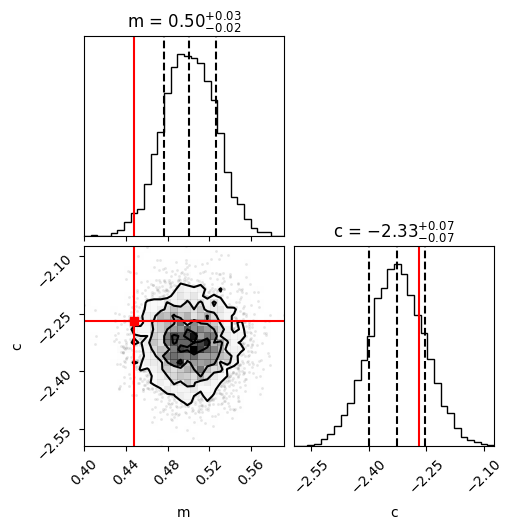

In [22]:
data = samples.squeeze(0).numpy() 

# Generate the corner plot
figure = corner.corner(
    data,
    bins=30,  # Number of bins
    labels=["m", "c"],
    quantiles=[0.16, 0.5, 0.84],  # Show median and 1-sigma
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=theta_test.numpy(),
    truth_color="red",
)

# Show the plot
# plt.axvline(x=0, color='k', linestyle='--')
plt.show()


In [22]:
test_data[0]

(tensor([-2.5590, -0.1755]),
 tensor([  9.3727,   8.3893,   9.6928,   9.2730,   9.3358,   8.6212,   7.9157,
           7.7010,   8.6288,   7.9638,   7.2164,   7.8816,   8.1762,   6.9408,
           6.5487,   7.5423,   6.9755,   6.6360,   5.0060,   6.0467,   6.6472,
           4.3269,   5.8918,   4.8817,   4.8267,   5.4301,   3.9217,   3.6803,
           5.3760,   3.4900,   4.0802,   3.2430,   3.8695,   3.4327,   2.6298,
           2.3794,   2.5952,   2.8192,   2.9652,   1.8439,   1.6050,   0.8870,
           1.3190,   1.8649,   0.4962,   1.3286,   0.1656,   0.2295,   0.0910,
          -0.2490,  -0.7759,  -0.2873,  -1.4592,  -1.0839,  -1.8737,  -1.4803,
          -1.9206,  -1.6923,  -1.5124,  -2.4125,  -2.5801,  -2.2175,  -3.3081,
          -3.5067,  -4.0996,  -4.8315,  -3.7372,  -4.0803,  -3.4822,  -5.0927,
          -4.0183,  -4.3456,  -5.6709,  -4.0782,  -3.4109,  -5.1302,  -5.5819,
          -7.3064,  -5.8927,  -5.1037,  -7.0520,  -6.8239,  -7.6399,  -8.0381,
          -8.0837,  -6.